In [2]:
!pip install tensorflow
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk

##TTF Example for MAF
tfd = tfp.distributions
tfb = tfp.bijectors

     |████████████████████████████████| 454.3 MB 4.0 kB/s eta 0:00:01    |██▏                             | 30.4 MB 5.3 MB/s eta 0:01:20     |██▎                             | 33.0 MB 3.8 MB/s eta 0:01:51     |██▍                             | 33.6 MB 3.8 MB/s eta 0:01:51     |███▊                            | 52.6 MB 5.8 MB/s eta 0:01:10     |███████▉                        | 110.6 MB 7.5 MB/s eta 0:00:47     |████████▍                       | 118.9 MB 6.5 MB/s eta 0:00:52     |█████████                       | 127.1 MB 3.7 MB/s eta 0:01:28     |███████████▊                    | 166.2 MB 7.4 MB/s eta 0:00:39     |████████████                    | 169.3 MB 5.5 MB/s eta 0:00:52     |██████████████▌                 | 206.2 MB 3.3 MB/s eta 0:01:16     |██████████████▋                 | 207.4 MB 3.3 MB/s eta 0:01:15     |██████████████▊                 | 209.0 MB 3.3 MB/s eta 0:01:15     |█████████████████               | 240.1 MB 6.1 MB/s eta 0:00:36     |█████████████████               |

     |████████████████████████████████| 147 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 1.1 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=3ae9a53ddfdf239ba3196b36fb81e9435dc85d8ecd6ce30458c257c2b5d32313
  Stored in directory: /home/nayantara/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=36401 sha256=c311cead8bc9e5a2e137f5f77a213030e4c0ef55de7fc5e0e74d0cdbf22d0456
  Stored in directory: /home/nayantara/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built termcolor wrapt
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 20210203211748
    Uninstalling flatbuffers-20210203211748:
      Successfully uninstalled flatbuffers-20210203211748
  Attempting uninstall: opt-einsum
    Found existing installation: opt-einsum 0+u

In [15]:
def get_maf_model(dims):
    # A common choice for a normalizing flow is to use a Gaussian for the base
    # distribution.  (However, any continuous distribution would work.) Here, we
    # use `tfd.Sample` to create a joint Gaussian distribution with diagonal
    # covariance for the base distribution (note that in the Gaussian case,
    # `tfd.MultivariateNormalDiag` could also be used.)
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[32, 32], activation='relu')

    maf = tfd.TransformedDistribution(distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),  #Distribution to be sampled from
        bijector=tfb.MaskedAutoregressiveFlow(made))

    x_ = tfkl.Input(shape=(dims,), dtype=tf.float32)
    log_prob_ = maf.log_prob(x_)
    model = tfk.Model(x_, log_prob_)
    model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)
    return model, maf

In [ ]:


dims = 10

# A common choice for a normalizing flow is to use a Gaussian for the base
# distribution.  (However, any continuous distribution would work.) Here, we
# use `tfd.Sample` to create a joint Gaussian distribution with diagonal
# covariance for the base distribution (note that in the Gaussian case,
# `tfd.MultivariateNormalDiag` could also be used.)
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10], activation='relu')

maf = tfd.TransformedDistribution(distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),  #Distribution to be sampled from
    bijector=tfb.MaskedAutoregressiveFlow(made))

x_ = tfkl.Input(shape=(dims,), dtype=tf.float32)
log_prob_ = maf.log_prob(x_)
model = tfk.Model(x_, log_prob_)

In [ ]:
model.output_shape

(None,)

In [ ]:
x = maf.sample()  # Expensive; uses `tf.while_loop`, no Bijector caching.
maf.log_prob(x)   # Almost free; uses Bijector caching.
# Cheap; no `tf.while_loop` despite no Bijector caching.
maf.log_prob(tf.zeros(dims))

<tf.Tensor: shape=(), dtype=float32, numpy=-9.189385>

In [ ]:
[mtv.shape for mtv in maf.trainable_variables]

[TensorShape([10, 10]),
 TensorShape([10]),
 TensorShape([10, 10]),
 TensorShape([10]),
 TensorShape([10, 20]),
 TensorShape([20])]

### MVLognormal

In [ ]:
NSAMP=1000
based1 = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[dims])
data = tf.exp(based1.sample(NSAMP))

In [ ]:
np.mean(-maf.log_prob(data))

44.61646

In [ ]:
#loss = -tf.reduce_mean(maf.log_prob(x_samples))
#train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

batch_size = 25
model.fit(x=data,
          y=np.zeros((NSAMP, 0), dtype=np.float32), validation_split=0.1,
          batch_size=batch_size,
          epochs=50,  # Usually `n // batch_size`.
          shuffle=True,
          verbose=True)


Epoch 1/50
36/36 [==============================] - 1s 11ms/step - loss: 46.3035 - val_loss: 36.1101
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 38.6574 - val_loss: 33.0207
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 37.0219 - val_loss: 30.5366
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 33.7481 - val_loss: 28.6359
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 30.8650 - val_loss: 27.3270
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 29.2900 - val_loss: 26.4179
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 27.8952 - val_loss: 25.7670
Epoch 8/50
36/36 [==============================] - 0s 2ms/step - loss: 30.6761 - val_loss: 25.2997
Epoch 9/50
36/36 [==============================] - 0s 2ms/step - loss: 26.9486 - val_loss: 24.9265
Epoch 10/50
36/36 [==============================] - 0s 2ms/step - loss: 26.8526 - val_loss: 24.598

In [ ]:
dmean = np.mean(data, axis=0)
dcov = np.matmul(tf.transpose((data - dmean)), (data - dmean))/(NSAMP-1)
mvg = tfd.Sample(tfd.MultivariateNormalFullCovariance(loc=dmean, covariance_matrix=dcov))

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [ ]:
qgaussian = mvg.sample(10000)

In [ ]:
qmaf = maf.sample(10000)

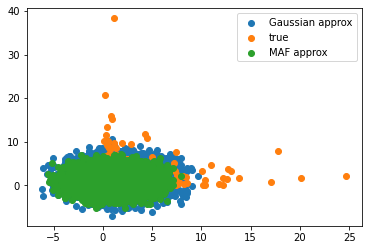

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(qgaussian[:, 0], qgaussian[:, 1], label='Gaussian approx')
plt.scatter(data[:, 0], data[:, 1], label='true')
plt.scatter(qmaf[:, 0], qmaf[:, 1], label='MAF approx')
plt.legend()
plt.show()

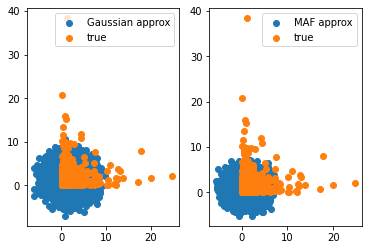

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, nrows=1)
ax[0].scatter(qgaussian[:, 0], qgaussian[:, 1], label='Gaussian approx')
ax[0].scatter(data[:, 0], data[:, 1], label='true')
ax[1].scatter(qmaf[:, 0], qmaf[:, 1], label='MAF approx')
ax[1].scatter(data[:, 0], data[:, 1], label='true')
ax[0].legend()
ax[1].legend()
plt.show()

### LogCoeffs

In [ ]:
import h5py
tfd = tfp.distributions
tfb = tfp.bijectors

f = h5py.File('reg_apd_noiso_logcoeff.jld2', 'r')
print(f.keys())

<KeysViewHDF5 ['_types', 'apdbool', 'codestring', 'dbncoeffs', 'dhc_args', 'filter_hash', 'isobool', 'logbool', 'sampcov', 'sampmean']>


In [ ]:
coeffs = f['dbncoeffs']
coeffs = np.array(coeffs).T
filter_hash = f['filter_hash']

In [ ]:
masktriu = np.triu(np.ones((34, 34)))
mask = np.zeros(1192)
mask[36:] = masktriu.flatten()

In [ ]:
coeffs_triu = coeffs[:, np.array(mask, dtype=np.bool)]

In [ ]:
coeffs_triu.shape

(10000, 595)

In [ ]:
modcoeffs, mafcoeffs = get_maf_model(595)
batch_size = 50
NSAMP = coeffs_triu.shape[0]
modcoeffs.fit(x=coeffs_triu, y=np.zeros((NSAMP, 0), dtype=np.float32), validation_split=0.1,
          batch_size=batch_size, epochs=100,  # Usually `n // batch_size`.
          shuffle=True, verbose=True)


Epoch 1/100
180/180 [==============================] - 3s 11ms/step - loss: 4775.1877 - val_loss: 891.7315
Epoch 2/100
180/180 [==============================] - 1s 6ms/step - loss: 793.3962 - val_loss: 577.2341
Epoch 3/100
180/180 [==============================] - 1s 6ms/step - loss: 542.4168 - val_loss: 441.2399
Epoch 4/100
180/180 [==============================] - 1s 6ms/step - loss: 429.2006 - val_loss: 447.4180
Epoch 5/100
180/180 [==============================] - 1s 6ms/step - loss: 371.0976 - val_loss: 313.8260
Epoch 6/100
180/180 [==============================] - 1s 6ms/step - loss: 315.6543 - val_loss: 279.0809
Epoch 7/100
180/180 [==============================] - 1s 6ms/step - loss: 278.1755 - val_loss: 249.8728
Epoch 8/100
180/180 [==============================] - 1s 6ms/step - loss: 248.2059 - val_loss: 217.5628
Epoch 9/100
180/180 [==============================] - 1s 6ms/step - loss: 218.0451 - val_loss: 195.8363
Epoch 10/100
180/180 [==============================]

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


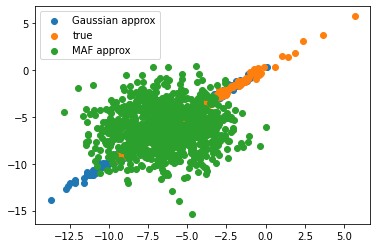

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
#bs=100: 327 after 500
#50: 169 after 500
dmean = np.mean(coeffs_triu, axis=0)
dcov = np.matmul(tf.transpose((coeffs_triu - dmean)), (coeffs_triu - dmean))/(NSAMP-1)
mvg = tfd.Sample(tfd.MultivariateNormalFullCovariance(loc=dmean, covariance_matrix=dcov))
qgaussian = mvg.sample(1000)
qmaf = mafcoeffs.sample(1000)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(qgaussian[:, 0], qgaussian[:, 1], label='Gaussian approx')
plt.scatter(coeffs_triu[:1000, 0], coeffs_triu[:1000, 1], label='true')
plt.scatter(qmaf[:, 0], qmaf[:, 1], label='MAF approx')
plt.legend()
plt.show()

### Moons test

In [5]:
import sklearn.datasets as skds

data = skds.make_moons(1000)
data[0].shape

(1000, 2)

In [ ]:
inputdbn = data[0]
modcoeffs, mafcoeffs = get_maf_model(2)
batch_size = 50
NSAMP = inputdbn.shape[0]
modcoeffs.fit(x=inputdbn, y=np.zeros((NSAMP, 0), dtype=np.float32), validation_split=0.1,
          batch_size=batch_size, epochs=100,  # Usually `n // batch_size`.
          shuffle=True, verbose=True)


Epoch 1/100
18/18 [==============================] - 1s 12ms/step - loss: 2.3439 - val_loss: 2.0547
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 2.0388 - val_loss: 2.0574
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 1.9804 - val_loss: 1.9658
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 1.8954 - val_loss: 1.8664
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 1.8152 - val_loss: 1.8248
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 1.7408 - val_loss: 1.7971
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 1.6434 - val_loss: 1.6452
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 1.6454 - val_loss: 1.5962
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 1.5679 - val_loss: 1.6632
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 1.4738 - val_loss: 1.5533
Epoch 11

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


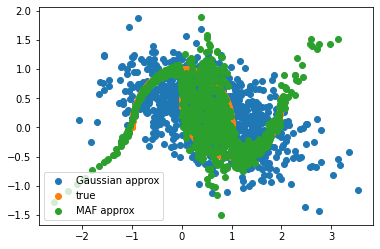

In [ ]:
#bs=100: 327 after 500
#50: 169 after 500
dmean = np.mean(inputdbn, axis=0)
dcov = np.matmul(tf.transpose((inputdbn - dmean)), (inputdbn - dmean))/(NSAMP-1)
mvg = tfd.Sample(tfd.MultivariateNormalFullCovariance(loc=dmean, covariance_matrix=dcov))
qgaussian = mvg.sample(1000)
qmaf = mafcoeffs.sample(1000)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(qgaussian[:, 0], qgaussian[:, 1], label='Gaussian approx')
plt.scatter(inputdbn[:1000, 0], inputdbn[:1000, 1], label='true')
plt.scatter(qmaf[:, 0], qmaf[:, 1], label='MAF approx')
plt.legend()
plt.show()

In [ ]:
### 

In [11]:
dimlist = []
rng= np.random.default_rng(seed=4)
for n in range(300):
    data = skds.make_moons(100000)
    scdata = (data[0] + rng.uniform(low=0.0, high=1.0, size=1)[0]) * rng.uniform(low=0.0, high=1.0, size=1)[0]
    dimlist.append(scdata)

In [12]:
inputdbn = np.hstack(dimlist)

In [16]:
modcoeffs, mafcoeffs = get_maf_model(600)
batch_size = 50
NSAMP = inputdbn.shape[0]
modcoeffs.fit(x=inputdbn, y=np.zeros((NSAMP, 0), dtype=np.float32), validation_split=0.1,
          batch_size=batch_size, epochs=100,  # Usually `n // batch_size`.
          shuffle=True, verbose=True)


Epoch 1/100
1800/1800 [==============================] - 6s 3ms/step - loss: 90.1391 - val_loss: 51.5402
Epoch 2/100
1800/1800 [==============================] - 5s 3ms/step - loss: 47.9208 - val_loss: 45.9098
Epoch 3/100
1800/1800 [==============================] - 5s 3ms/step - loss: 45.3695 - val_loss: 44.8656
Epoch 4/100
1800/1800 [==============================] - 5s 3ms/step - loss: 44.4210 - val_loss: 43.8804
Epoch 5/100
1800/1800 [==============================] - 6s 3ms/step - loss: 43.9450 - val_loss: 43.3488
Epoch 6/100
1800/1800 [==============================] - 6s 3ms/step - loss: 43.6354 - val_loss: 43.2971
Epoch 7/100
1800/1800 [==============================] - 6s 3ms/step - loss: 43.3833 - val_loss: 43.1345
Epoch 8/100
1800/1800 [==============================] - 6s 3ms/step - loss: 43.1765 - val_loss: 43.0019
Epoch 9/100
1800/1800 [==============================] - 6s 3ms/step - loss: 43.1311 - val_loss: 43.0440
Epoch 10/100
1800/1800 [==============================]

1800/1800 [==============================] - 5s 3ms/step - loss: 42.3337 - val_loss: 42.2198
Epoch 79/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3408 - val_loss: 42.4608
Epoch 80/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3362 - val_loss: 42.2177
Epoch 81/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3301 - val_loss: 42.3665
Epoch 82/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3189 - val_loss: 42.2010
Epoch 83/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3270 - val_loss: 42.4068
Epoch 84/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3304 - val_loss: 42.3278
Epoch 85/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3275 - val_loss: 42.3949
Epoch 86/100
1800/1800 [==============================] - 5s 3ms/step - loss: 42.3209 - val_loss: 42.2001
Epoch 87/100
1800/1800 [==============================] - 5

In [ ]:
#bs=100: 327 after 500
#50: 169 after 500
dmean = np.mean(inputdbn, axis=0)
dcov = np.matmul(tf.transpose((inputdbn - dmean)), (inputdbn - dmean))/(NSAMP-1)
mvg = tfd.Sample(tfd.MultivariateNormalFullCovariance(loc=dmean, covariance_matrix=dcov))
qgaussian = mvg.sample(1000)
qmaf = mafcoeffs.sample(1000)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(qgaussian[:, 0], qgaussian[:, 1], label='Gaussian approx')
plt.scatter(inputdbn[:1000, 0], inputdbn[:1000, 1], label='true')
plt.scatter(qmaf[:, 0], qmaf[:, 1], label='MAF approx')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0d83dd8d-0eb0-452c-aca5-caf644e7d9c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>